# Config

In [20]:
import os
import json
import time
import torch
import pprint
import random
import pandas
import argparse
import lightning


import numpy as np
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset

In [43]:
root_dir = "../../../simulation/dataset-CL"
molecule = "alanine"
temperature = "1200.0"
version = "v4"

In [44]:
class CL_dataset(Dataset):
    def __init__(
        self,
        data_list,
        data_augmented_list,
        data_augmented_hard_list,
        temperature_list,
        energy_list
    ):
        super(CL_dataset, self).__init__()
        self.device = "cpu"
        
        self.x = data_list.to(self.device)
        self.x_augmented = data_augmented_list.to(self.device)
        self.x_augmented_hard = data_augmented_hard_list.to(self.device)
        self.temperature = temperature_list.to(self.device)
        self.energy = energy_list.to(self.device)
        
    def __getitem__(self, index):
	    return self.x[index], self.x_augmented[index], self.x_augmented_hard[index], self.temperature[index], self.energy[index]
 
    def __len__(self):
	    return self.x.shape[0]

In [45]:
dataset_dir = f"{root_dir}/{molecule}/{temperature}/{version}"
dataset = torch.load(f"{dataset_dir}/cl-xyz.pt")

# Preprocess

In [47]:
def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	angles = np.array(list(map(dihedral, positions)))
	return angles

In [48]:
PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
phi_list = []
psi_list = []
state_list = []
energy_list = []

for data in tqdm(dataset):
	current_state, _, _, _, energy = data
	state_list.append(current_state)
	energy_list.append(energy)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [49]:
state_list = np.stack(state_list)
state_list.shape

(200000, 22, 3)

In [50]:
state_phi_list = compute_dihedral(state_list[:, PHI_ANGLE])
state_psi_list = compute_dihedral(state_list[:, PSI_ANGLE])
print(state_phi_list.shape, state_psi_list.shape)

(200000,) (200000,)


In [51]:
np.save(f"{dataset_dir}/phi.npy", state_phi_list)
np.save(f"{dataset_dir}/psi.npy", state_psi_list)

# Visualization

In [52]:
start_state_xyz = md.load(f"./c5.pdb").xyz
goal_state_xyz = md.load(f"./c7ax.pdb").xyz
start_state = torch.tensor(start_state_xyz)
goal_state = torch.tensor(goal_state_xyz)
phi_start = compute_dihedral(start_state[:, PHI_ANGLE])
psi_start = compute_dihedral(start_state[:, PSI_ANGLE])
phi_goal = compute_dihedral(goal_state[:, PHI_ANGLE])
psi_goal = compute_dihedral(goal_state[:, PSI_ANGLE])

<Figure size 640x480 with 0 Axes>

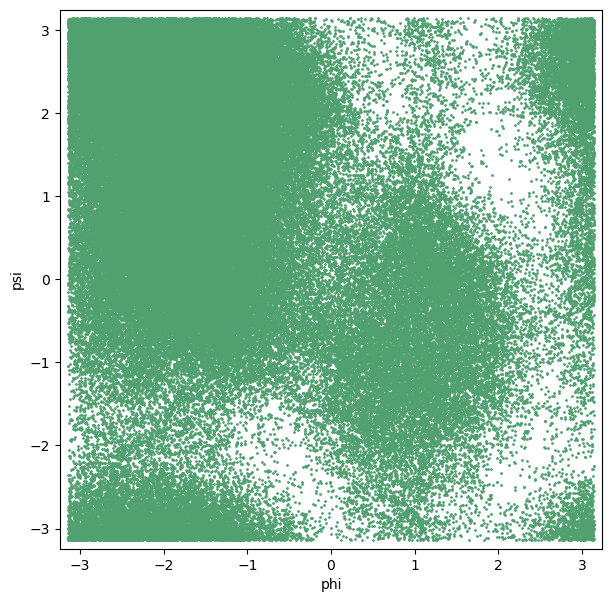

In [85]:
plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.plot(
	state_phi_list,
	state_psi_list,
	marker="o",
	linestyle="None",
	markersize=1,
	alpha=1.0,
	zorder=100,
 	color="#50A070",
)
# Plot the Ramachandran plot
plt.xlim([-np.pi - 0.1, np.pi + 0.1])
plt.ylim([-np.pi - 0.1, np.pi + 0.1])
plt.xlabel("phi")
plt.ylabel("psi")
plt.show()

<Figure size 640x480 with 0 Axes>

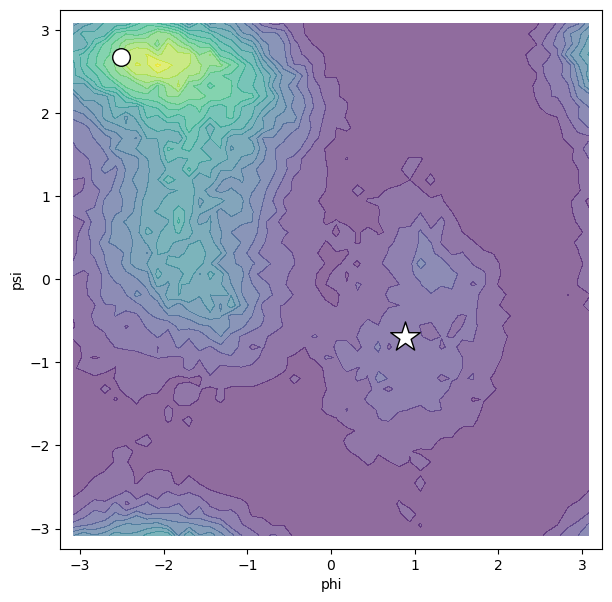

In [54]:
plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# Create a 2D histogram (contour plot) from the coordinates
hist, xedges, yedges = np.histogram2d(state_phi_list, state_psi_list, bins=50, range=[[-np.pi, np.pi], [-np.pi, np.pi]])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)
ax.contourf(X, Y, hist.T, levels=20, cmap='viridis', alpha=0.6)

# Plot start and goal states
ax.scatter(phi_start, psi_start, edgecolors="black", c="w", zorder=101, s=160)
ax.scatter(phi_goal, psi_goal, edgecolors="black", c="w", zorder=101, s=500, marker="*")

# Plot the Ramachandran plot
plt.xlim([-np.pi - 0.1, np.pi + 0.1])
plt.ylim([-np.pi - 0.1, np.pi + 0.1])
plt.xlabel("phi")
plt.ylabel("psi")
plt.show()

In [57]:
energy_min, energy_max = np.min(energy_list), np.max(energy_list)
print(energy_min,energy_max)

-84.37466089607551 444.0888928899221


In [58]:
number_of_bins = 9

In [66]:
df = pd.DataFrame(np.array([energy_list, state_phi_list, state_psi_list]).T, columns=["energy", "phi", "psi"])
df

,energy,phi,psi
0,71.924046,-1.293704,1.239066
1,158.522263,-1.176975,-2.789778
2,120.484959,-1.118715,1.403658
3,161.483075,-0.843757,3.089951
4,210.666076,-1.814873,-3.070586
...,...,...,...
199995,45.704408,-2.712384,-2.809461
199996,62.726224,-1.723861,0.888029
199997,169.394541,-1.304561,1.647248
199998,113.705218,0.823040,-0.830486


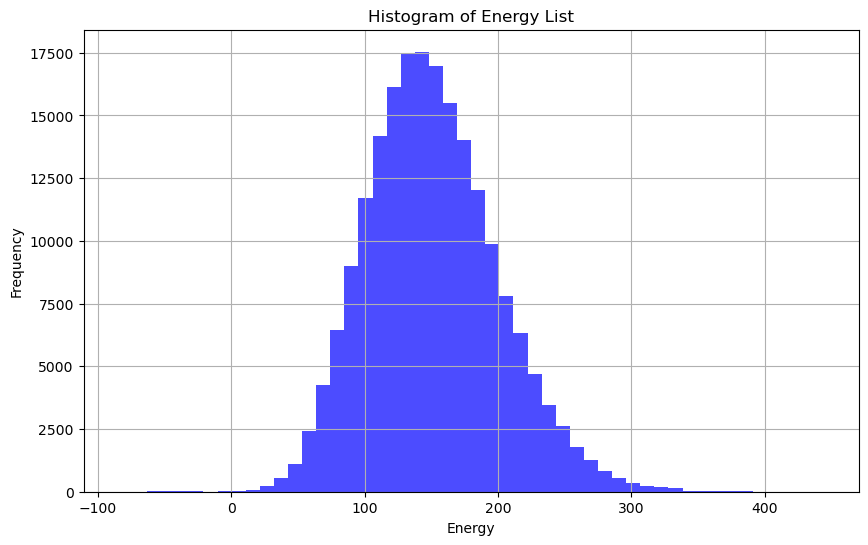

In [81]:
plt.figure(figsize=(10, 6))
plt.hist(energy_list, bins=50, color='blue', alpha=0.7)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of Energy List')
plt.grid(True)
plt.show()

In [82]:
bins = np.percentile(energy_list, np.linspace(0, 100, 11))
print(bins)

[-84.3746609   90.77892541 109.1134992  123.07841489 135.35757196
 147.38609756 159.89592052 173.94195831 190.69441335 215.49267164
 444.08889289]


In [90]:
bins = np.array([-100, 80, 100, 120, 140, 160, 180, 200, 450])

  0%|          | 0/8 [00:00<?, ?it/s]

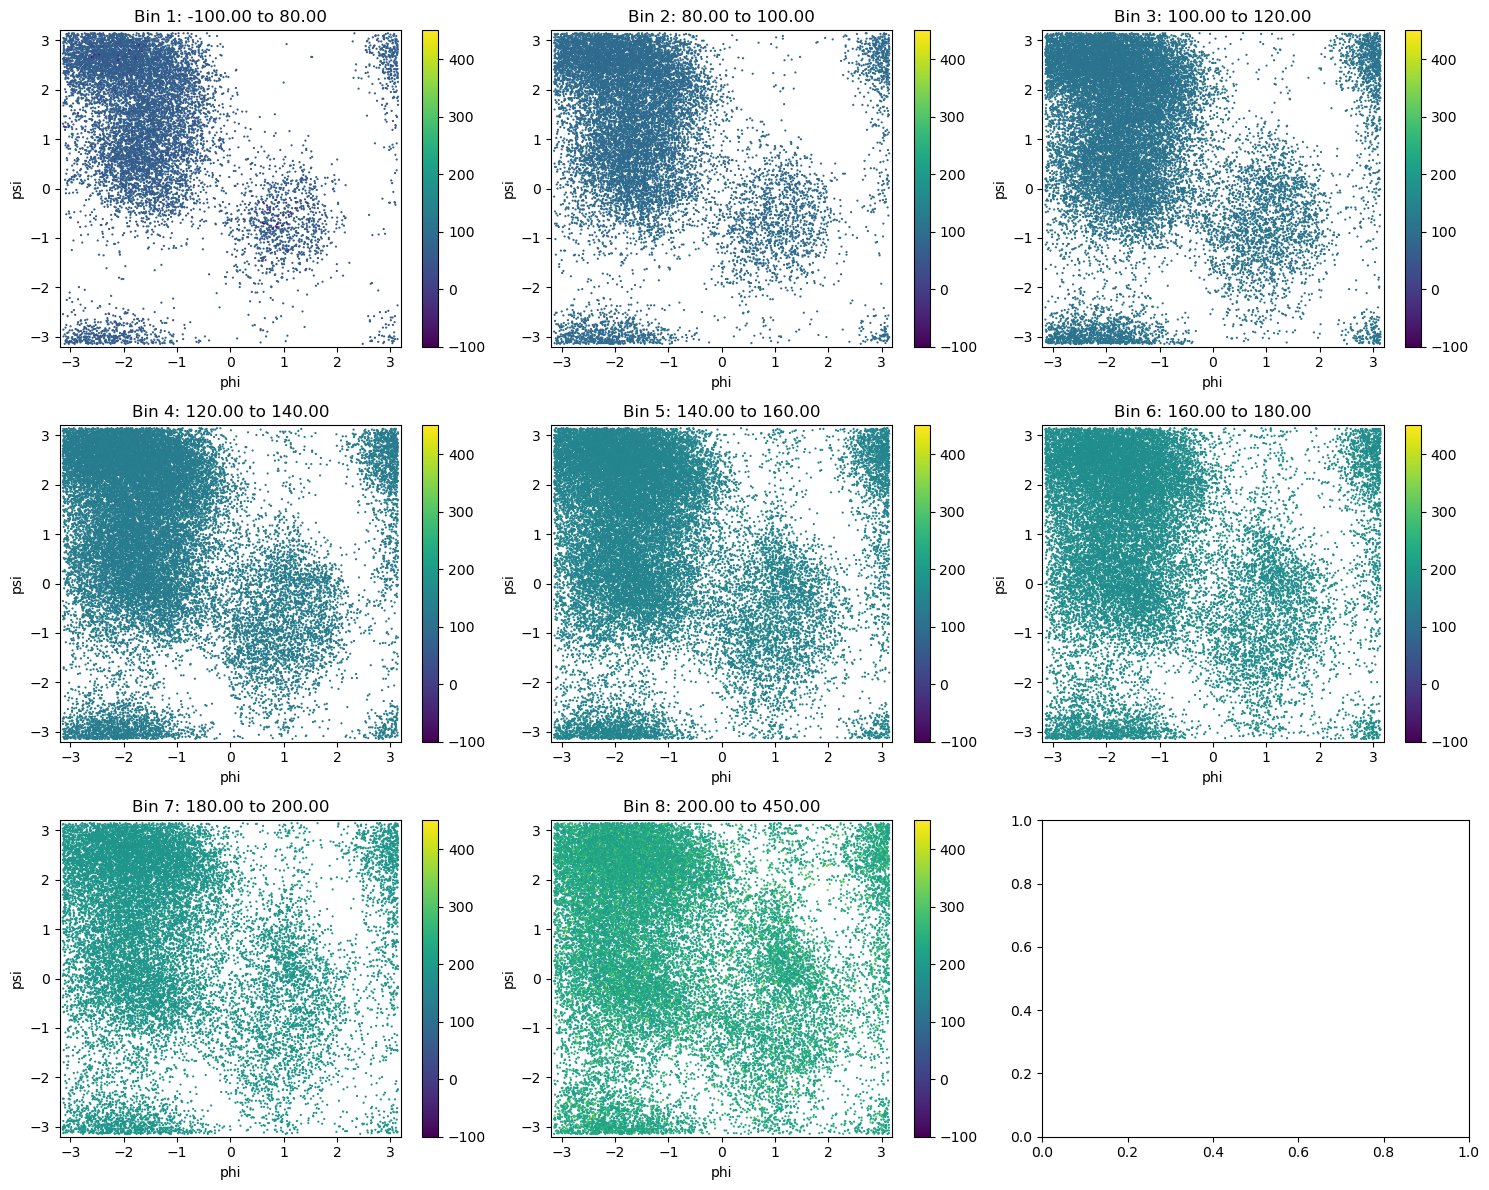

In [91]:
fig,axs = plt.subplots(3, 3, figsize = ( 15, 12 ) )
axs = axs.ravel()

for i in tqdm(
    range(0, min(len(bins)-1, 9))
):
	ax = axs[i]
	df_selected = df[(df[f'energy'] <= bins[i+1]) & (df[f'energy'] >= bins[i])]
	df_selected.plot.hexbin(
		'phi', 'psi', C=f'energy',
		vmin = bins[0], vmax = bins[-1],
		cmap = "viridis", ax = ax,
		gridsize = 400,
	)
	ax.set_title(f"Bin {i+1}: {bins[i]:.2f} to {bins[i+1]:.2f}")
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)
	plt.tight_layout()